## First install all required packages to run this notebook.

In [229]:
!pip3 install numpy pandas scikit-learn torch matplotlib seaborn tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


## Define settings and model configurations

In [230]:
params = {
    "data": [
        'bug',
        'feature',
        'rating',
        'user_experience'
    ],
    # Whether to combine all negative classes into one
    'single_negative': False,
    "comment_type": 
        #'stopwords',
        #'stopwords_nltk',
        #'stopwords_lemmatization',
        #'lemmatization',
        #'stemming',
        "comment",
    "preprocess_steps": [
        "special_characters",
        #"remove_punctuation",
        #"possessove_pronouns",
    ],
    "text_representation": {
        'method': 'tfidf',
        'ngram_range': (1, 2),
        'max_features': 500,
        'max_df': 0.8,
        'min_df': 0.01
    },
    "randomForest": {
        "param_grid": {
            # Hyper-parameter tuning for Random Forest
            'n_estimators': [100, 300, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [20, 80, None],
            'min_samples_split': [2, 5, 10]
        },
        "search": {
            'method': 'grid',
            'cv': 5,
            'verbose': 2,
            'n_jobs': -1,
            'n_iter': 100
        }

    },
    "lstm": {
        "vocab_size": 5000,
        "embedding_dim": 100,
        "hidden_size": 64,
        "num_classes": None,
        "dropout": 0.3,
        "embedding_matrix": None,
    }
}

## Data Preprocessing


In [231]:
data_paths = {
  "bug": 'Bug_tt.json',
  "feature": 'Feature_tt.json',
  "rating": 'Rating_tt.json',
  "user_experience": 'UserExperience_tt.json'
}

In [232]:
import json
import pandas as pd
import os
import numpy as np

labels = []

def load_data(params, cleaner):
  X, y = [], []
  for label in params["data"]:
    labels.append(label)
    labels.append('not_' + label)
    # Load data
    with open(os.path.join('data', data_paths[label])) as f:
      data_lst = json.load(f)
      for data in data_lst:
        X.append(cleaner.preprocess(data)) 
        y.append(data['label'])
  return np.array(X), np.array(y)

### Preprocessing Steps
1. Text Cleaning:
  - Preprocessed Comment Selection:
    1. stopwords_removal
    2. stopwords_removal_nltk
    3. stopwords_removal_lemmatization
    4. lemmatized_comment
    5. stemmed
  - Other Proprocessing Steps:
    1. remove_special_characters
    2. remove_punctuation
    3. remove_possessive_pronouns
2. Label Encoding.
3. Train-Test Split.
4. Text Representation:
  - TF-IDF.
  - Word2Vec.

In [233]:
# Text Cleaning
import re
import string

class TextCleaner:
  def __init__(self, settings):
    self.settings = settings
  
  # Selection of pre-processed comments
  def select_comment(self):
    if self.commentType == 'stopwords': 
      self._remove_stopwords()
    elif self.commentType == 'stopwords_nltk':
      self._remove_stopwords_nltk()
    elif self.commentType == 'stopwords_lemmatization':
      self._removal_stopwords_lemmatization()
    elif self.commentType == 'lemmatization':
      self._lemmatization()
    elif self.commentType == 'stemming':
      self._stemming()
    else:
      self.X = self.data['comment']
  
  def _remove_stopwords(self):
    self.X = self.data['stopwords_removal']

  def _remove_stopwords_nltk(self):
    self.X = self.data['stopwords_removal_nltk']

  def _removal_stopwords_lemmatization(self):
    self.X = self.data['stopwords_removal_lemmatization']

  def _lemmatization(self):
    self.X = self.data['lemmatized_comment']

  def _stemming(self):
    self.X = self.data['stemmed']

  # Selection of pre-processed comments
  def preprocess_comment(self):
    if 'special_characters' in self.preprocess_steps:
      self._remove_special_characters()
    if 'remove_punctuation' in self.preprocess_steps:
      self._remove_punctuation()
    if 'possessove_pronouns' in self.preprocess_steps:
      self._possessive_pronouns()

  def _remove_special_characters(self):
    pattern = r'[^a-zA-Z0-9\s' + re.escape(string.punctuation) + r']'
    self.X = re.sub(pattern, '', self.X)

  def _remove_punctuation(self):
    pattern = r'[^\w\s]'
    self.X = re.sub(pattern, '', self.X)
  
  def _possessive_pronouns(self):
    pattern = r"\'s\b|\'m\b|\'are\b"
    self.X = re.sub(pattern, '', self.X)

  def preprocess(self, data):
    self.data = data

    self.commentType = self.settings['comment_type']
    self.select_comment()
  
    self.preprocess_steps = self.settings['preprocess_steps']
    self.preprocess_comment()
    
    return self.X

### Initialize the TextCleaner based on params

In [234]:
textCleaner = TextCleaner(params)
X, y = load_data(params, textCleaner)

### Label Encode the y data (whether to combine all negative cases into one)

In [235]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_encoding(y_data, single_negative=False):
  label_encoder = LabelEncoder()
  if single_negative:
    # all label started with no_ will be considered as negative
    y_data = ['negative' if 'no_' in label else label for label in y_data]
  y_encoded = label_encoder.fit_transform(y_data)

  return y_encoded

y = label_encoding(y)

### Splitting data into training and testing sets

In [236]:
# Train-Test Split
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2, random_state=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=test_size,
                                                      random_state=random_state,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test

In [237]:
X_train, X_test, y_train, y_test = split_data(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2268,) (568,) (2268,) (568,)


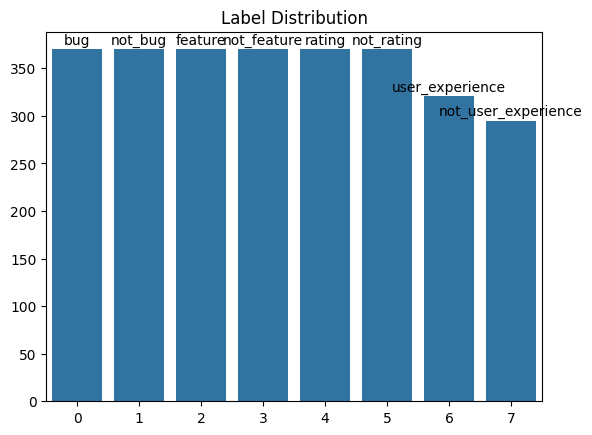

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the label distribution for all data
def plot_label_distribution(y):
    ax = sns.barplot(x=np.unique(y), y=pd.Series(y).value_counts().values)
    plt.title('Label Distribution')
    # label the bars
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom')
    plt.show()

plot_label_distribution(y)

### Define Text Representation

In [239]:
# Text Representation
from sklearn.feature_extraction.text import TfidfVectorizer

class TextRepresenter:
    def __init__(self, params):
        self.settings = params['text_representation']
        if self.settings['method'] == 'tfidf':
            self.tfidf = TfidfVectorizer(encoding='utf-8',
                                        ngram_range=self.settings['ngram_range'],
                                        stop_words=None,
                                        lowercase=False,
                                        max_df=self.settings['max_df'],
                                        min_df=self.settings['min_df'],
                                        max_features=self.settings['max_features'],
                                        norm='l2',
                                        sublinear_tf=True)

    def fit_transform(self, X):
        return self.tfidf.fit_transform(X).toarray()               


In [240]:
text_representation = TextRepresenter(params)
X_train_embed = text_representation.fit_transform(X_train)
X_test_embed = text_representation.tfidf.transform(X_test).toarray()

## Define Traditional ML Method

In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, hamming_loss

class TextRandomForest:
  def __init__(self, params):
    self.model = RandomForestClassifier()
    self.param_grid = params["param_grid"]

    if params["search"]["method"] == 'grid':
      self.search_config = params["search"]
      self.model_selector = GridSearchCV(estimator=self.model,
                                         param_grid=self.param_grid,
                                         scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
                                         refit='f1_macro',
                                         cv=self.search_config["cv"],
                                         verbose=self.search_config["verbose"],
                                         n_jobs=self.search_config["n_jobs"])
    elif params["search"]["method"] == 'random':
      self.search_config = params["search"]
      self.model_selector = RandomizedSearchCV(estimator=self.model,
                                               param_distributions=self.param_grid,
                                               scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
                                               refit='f1_macro',
                                               n_iter=self.search_config["n_iter"],
                                               cv=self.search_config["cv"],
                                               verbose=self.search_config["verbose"],
                                               random_state=42,
                                               n_jobs=self.search_config["n_jobs"])
    else:
      raise ValueError("Search type must be either grid or random.")

  def fit(self, X_train, y_train):
    self.model_selector.fit(X_train, y_train)
    self.best_estimator_ = self.model_selector.best_estimator_

  def predict(self, X_test):
    return self.best_estimator_.predict(X_test)

  def evaluate(self, X_test, y_test):
    # Calculate various performance metrics
    predictions = self.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')  # You can use other averages like 'micro', 'weighted'
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    report = classification_report(y_test, predictions)

    # Optional: Calculate Hamming Loss, useful for multi-label
    ham_loss = hamming_loss(y_test, predictions)

    # Print or return all the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Hamming Loss: {ham_loss}")
    print("\nClassification Report:\n", report)

    # You can choose to return these metrics in a dictionary if you prefer
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "hamming_loss": ham_loss,
        "classification_report": report
    }

  def best_params(self):
    return self.model_selector.best_params_

In [242]:
# Train Random Forest
random_forest = TextRandomForest(params["randomForest"])
random_forest.fit(X_train_embed, y_train)
result = random_forest.evaluate(X_test_embed, y_test)
print(result)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=20, max_features=sq

## Define CNN Model

In [243]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
  def __init__(self, params):
    super(TextCNN, self).__init__()
    import pdb; pdb.set_trace()
    self.embedding = nn.Embedding(params["vocab_size"], params["embed_size"])
    self.embedding.weight = nn.Parameter(torch.tensor(params["embedding_matrix"],
                                                      dtype=torch.float32))
    self.embedding.weight.requires_grad = True

    self.convs = nn.ModuleList([nn.Conv2d(1, params["num_filters"],
                               (K, params["embed_size"]))
                               for K in params["filter_sizes"]])
    self.relu = nn.ReLu()
    self.maxpool = n.MaxPool1d()
    self.dropout = nn.Dropout(params["dropout"])
    self.fc = nn.Linear(len(params["filter_sizes"]) * params["num_filters"],
                        params["num_classes"])

  def forward(self, X):
    X_embedding = self.embedding(X)
    X = X_embedding.unsqueeze(1)
    X = [self.relu(conv(X)).squeeze(3) for conv in self.convs]
    X = [self.maxpool1d(x, x.size(2)).squeeze(2) for x in X]
    X = torch.cat(X, 1)
    X = self.dropout(X)
    return self.fc(X)


## Define LSTM Model

In [287]:
class TextLSTM(nn.Module):
  def __init__(self, params):
    super(TextLSTM, self).__init__()

    self.hidden_size = params["hidden_size"]
    # Embedding layer tooks two arguments: vocab_size and embedding_dim
    self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])#,
                                  #input_length=params["max_length"])
    self.embedding.weight = nn.Parameter(torch.tensor(params["embedding_matrix"],
                                                      dtype=torch.float32))
    self.embedding.weight.requires_grad = True

    self.lstm = nn.LSTM(params["embedding_dim"], self.hidden_size,
                        bidirectional=True, batch_first=True)
    self.linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(params["dropout"])
    self.fc = nn.Linear(self.hidden_size, params['num_classes'])

  def forward(self, X):
    print("Input X shape:", X.shape)
    X = self.embedding(X)
    print("After embedding:", X.shape)
    X, _ = self.lstm(X)
    print("After LSTM:", X.shape)
    # Assuming the LSTM is bidirectional and you want to concatenate the last forward and first backward states
    X = torch.cat((X[:, -1, :self.hidden_size], X[:, 0, self.hidden_size:]), dim=1)

    print("After concat:", X.shape)
    X = self.linear(X)
    print("After first linear layer:", X.shape)
    X = self.relu(X)
    X = self.dropout(X)
    X = self.fc(X)
    print("Final output:", X.shape)
    return X

    return X


### Tokenize the data

In [271]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 500
tokenizer = Tokenizer(num_words=vocab_size)
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
max_len = max([len(x) for x in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

# Fit the tokenizer on the test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [285]:
lstm_params = params["lstm"]
lstm_params["num_classes"] = len(np.unique(y))

# vocab_size is the number of unique words in your dataset and embedding_dim is the dimension of the word vectors
lstm_params["embedding_dim"] = X_train_embed.shape[1]
lstm_params["vocab_size"] = vocab_size
lstm_params["embedding_matrix"] = X_train_embed
lstm_params["max_length"] = max_len

In [290]:
lstm = TextLSTM(lstm_params)
lstm.forward(torch.tensor(X_train_pad))
# evaluate model
lstm.eval()
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    output = lstm(torch.tensor(X_test_pad))
    loss = criterion(output, torch.tensor(y_test))
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == torch.tensor(y_test)).sum().item() / len(y_test)
    recall = recall_score(y_test, predicted, average='macro')
    f1 = f1_score(y_test, predicted, average='macro')
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

Input X shape: torch.Size([2268, 593])
After embedding: torch.Size([2268, 593, 472])
After LSTM: torch.Size([2268, 593, 128])
After concat: torch.Size([2268, 128])
After first linear layer: torch.Size([2268, 64])
Final output: torch.Size([2268, 8])
Input X shape: torch.Size([568, 593])
After embedding: torch.Size([568, 593, 472])
After LSTM: torch.Size([568, 593, 128])
After concat: torch.Size([568, 128])
After first linear layer: torch.Size([568, 64])
Final output: torch.Size([568, 8])
Accuracy: 0.13028169014084506
Recall: 0.125
F1 Score: 0.02881619937694704


Useful links: https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c